In [4]:
from tahoe import execute_async
import pandas as pd
import json

In [2]:
execute_async("""SELECT COUNT(*) FROM sweeper.attribute_extraction_events WHERE action=4""")

[(17016,)]

In [7]:
res = execute_async("""SELECT task_id, extraction_result, dt, hr FROM sweeper.attribute_extraction_events WHERE action=4""")

In [8]:
df = pd.DataFrame(res)

In [10]:
df.columns = ['task_id', 'extraction_result', 'dt', 'hr']

In [11]:
df

,task_id,extraction_result,dt,hr
0,product_attribution_md_323c428b7996b8cba6a80fb...,"{""Age Range Description"": [""Not Sure""], ""Patte...",2023-03-20,9
1,product_attribution_md_aa58499404131e48fa509f2...,"{""Item Weight (Include Unit of Measure)"": [""No...",2023-03-20,9
2,product_attribution_md_d4be4a2dc0c77705a2023f0...,"{""Boot Opening (Include Unit of Measure)"": [""N...",2023-03-20,9
3,product_attribution_md_e465bd5948a1aa1defc8298...,"{""Item Weight (Include Unit of Measure)"": [""No...",2023-03-20,9
4,product_attribution_md_673c7fd683910f873155f5a...,"{""Styles"": [""Not Sure""], ""Age Range Descriptio...",2023-03-20,9
...,...,...,...,...
17011,product_attribution_md_e6676d77de081c4db4059a3...,"{""Model or Model Number"": [""Not Sure""], ""Brand...",2023-03-31,11
17012,product_attribution_md_af81f12d74bd276bcefe6b6...,"{""Model or Model Number"": [], ""Brand Name"": []...",2023-03-31,11
17013,product_attribution_md_f67a3ae7d47e02391cd7196...,"{""Compatible Brand/Model"": [""Huawei""], ""Patter...",2023-03-31,11
17014,product_attribution_md_d443940020e57718cb4e545...,"{""Age Range Description"": [""Not Sure""], ""Prima...",2023-03-31,11


In [12]:
df_orig = pd.read_json('input/product_attr_extract_md_03252023.json', lines=True)

In [13]:
len(df_orig)

26066

In [14]:
df_merge = df_orig.merge(df, on='task_id', how='inner')

In [17]:
len(df_merge), len(set(df_merge.task_id))

(16018, 16018)

<Axes: ylabel='category_path'>

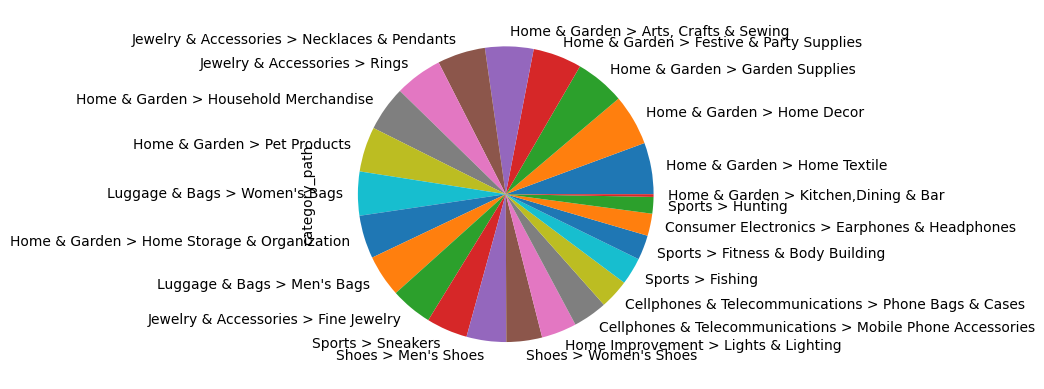

In [37]:
df_merge.category_path.apply(lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

In [44]:
rec = df_merge.sample(1).to_dict('records')[0]

In [47]:
{i: rec[i] for i in rec if i in ['category_path', 'title', 'product_description', 'extraction_result']}

{'category_path': 'Home & Garden > Home Textile > Carpets & Rugs > Carpets',
 'title': 'Cute Alpacas Pattern with Cactus Area Rug Non Slip Comfort Yoga Mat Floor Carpet Home Decor for Living Room Bedroom',
 'product_description': 'Printing instructions: full-frame product, single-sided printing\nMaterial description: flannel fabric (polyester)\nProduct performance: high-density space elastic cotton interlayer, water absorption, soft touch, fine fluff, no ball, no fading, the middle interlayer is high-density memory foam, which can effectively relieve foot pressure\nApplicable scenarios: Suitable for many occasions: living room, office, coffee table, bed, balcony, etc.\nProduct structure: The bottom of the floor mat is made of non-woven fabric + dot plastic bottom, which is more non-slip and durable\nWashing instructions: washable or machine washable, wear-resistant, no lint\nSpecial note: For the convenience of logistics and transportation, the floor mats will be folded and shipped. Cu

In [90]:
human_result = json.loads(rec['extraction_result'])

In [93]:
[(i, human_result[i]) for i in human_result if len(human_result[i]) > 0 and str(human_result[i][0]).lower().strip() != 'not sure']

[('Intended Usage', ['Indoor']),
 ('Materials', ['Polyester', 'Flannel']),
 ('Item Features', ['Washable'])]

# check oai quality compared to humans

In [66]:
import random

In [78]:
def sample_from_strified_list(t):
    l = eval(t)
    if len(l) > 1:
        return random.sample(l, min(3, len(l)))
    else:
        return "Free text, please extract from product title and description"

In [124]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
title = rec['title']
desp = rec['product_description']
attrs = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec['attribute_config']])
msgs = [
        {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data."""},
        {"role": "user", "content": """[title start] 316L Solid Stainless Steel  Necklace [title end] [description start] Authenticity Guaranteed
Hypoallergenic Jewelry
Comfort Fit Design
Safe on Skin
Made to Last a Lifetime
Designed in ITALY
Certifed Gemstones
Creation Method: Lab Created 
Guaranteed to Retain its Color and Shine
316L Solid Stainless Steel Necklace [description end]"""},
      {"role": "assistant", "content": """Department|Women
Materials|Argentium Plated Stainless Steel
Materials|Stainless Steel"""},
#       {"role": "user", "content": """[title start] Conjunto Deportivo Enei Iris [title end] [description start]  Conjunto deportivo de mujer Iris enei confeccionado con un tejido compresivo de secado rápido. Ideal para cualquier práctica deportiva este conjunto deportivo esta diseñado con el mínimo de costuras para un ajuste más cómodo y suave con efecto segunda piel. Realza la forma natural de la figura. tejido super suave, elástico y flexible sin transparencias, cintura alta, el top: tejido super suave, diseño de tiras cruzadas en la parte trasera, ajuste de abdomen, foam extraible. el legging: tejido super suave, elástico y flexible sin transparencias, cintura alta  [description end]"""},
#       {"role": "assistant", "content": """Alpha Size|One Size
# Body Closure|Elastic
# Department|Women
# Materials|Fabric"""},
      {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Note that our attribute definition is specific, and you need to follow our attribute definition. Please return a json so that I can parse, the values should always be a list. If not sure about a specific attribute, write ["Not Sure"] in the json as value. Here are some example values of attribute:
{attrs}"""}
    ]
res = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs,
  temperature=0
)

In [125]:
rec['title']

'Cute Alpacas Pattern with Cactus Area Rug Non Slip Comfort Yoga Mat Floor Carpet Home Decor for Living Room Bedroom'

In [131]:
print(attrs)

Age Range Description: ['Teen', 'Toddler', 'Infant']
Brand Name: Free text, please extract from product title and description
Care Instructions: ['No Machine Wash', 'Machine Wash Gentle', 'Machine Wash']
Construction: ['Hand Tufted', 'Hand Knotted', 'Hand Hooked']
Fabric Warmth Description: ['Lightweight', 'Medium/Heavyweight', 'Very Heavyweight']
Installation or Mount Compatibility: ['Static Cling', 'Peel and Stick', 'Heat Shrink']
Intended Usage: ['Indoor', 'Outdoor']
Is Stain Resistant: ['No', 'Yes']
Item Features: ['Scented', 'Inflatable', 'Stain-Resistant']
Item Height (Include Unit of Measure): Free text, please extract from product title and description
Item Length (Include Unit of Measure): Free text, please extract from product title and description
Item Width (Include Unit of Measure): Free text, please extract from product title and description
Manufacture Type: ['Handmade', 'Machine Made']
Material-Free: ['Phthalate-Free', 'PVC-Free', 'Lead-Free']
Materials: ['Stone', 'Stee

In [126]:
rec['product_description']

'Printing instructions: full-frame product, single-sided printing\nMaterial description: flannel fabric (polyester)\nProduct performance: high-density space elastic cotton interlayer, water absorption, soft touch, fine fluff, no ball, no fading, the middle interlayer is high-density memory foam, which can effectively relieve foot pressure\nApplicable scenarios: Suitable for many occasions: living room, office, coffee table, bed, balcony, etc.\nProduct structure: The bottom of the floor mat is made of non-woven fabric + dot plastic bottom, which is more non-slip and durable\nWashing instructions: washable or machine washable, wear-resistant, no lint\nSpecial note: For the convenience of logistics and transportation, the floor mats will be folded and shipped. Customers may receive creases. After leaving for 3-5 hours, the creases will disappear. Please rest assured to buy'

In [127]:
[(i, human_result[i]) for i in human_result if len(human_result[i]) > 0 and str(human_result[i][0]).lower().strip() != 'not sure']

[('Intended Usage', ['Indoor']),
 ('Materials', ['Polyester', 'Flannel']),
 ('Item Features', ['Washable'])]

In [128]:
json.loads(res['choices'][0]['message']['content'])

{'Age Range Description': ['All Ages'],
 'Brand Name': ['Not Sure'],
 'Care Instructions': ['Machine Washable'],
 'Construction': ['Not Sure'],
 'Fabric Warmth Description': ['Not Sure'],
 'Installation or Mount Compatibility': ['Not Applicable'],
 'Intended Usage': ['Indoor'],
 'Is Stain Resistant': ['Not Sure'],
 'Item Features': ['Non-Slip'],
 'Item Height (Include Unit of Measure)': ['Not Sure'],
 'Item Length (Include Unit of Measure)': ['Not Sure'],
 'Item Width (Include Unit of Measure)': ['Not Sure'],
 'Manufacture Type': ['Machine Made'],
 'Material-Free': ['Not Applicable'],
 'Materials': ['Polyester'],
 'Model or Model Number': ['Not Sure'],
 'Occasion & Lifestyle': ['Not Sure'],
 'Pattern': ['Alpacas', 'Cactus'],
 'Pile Height': ['Not Sure'],
 'Primary Color': ['Not Sure'],
 'Recommended Room': ['Living Room', 'Bedroom'],
 'Shape': ['Rectangle'],
 'Size': ['Not Sure'],
 'Styles': ['Not Sure'],
 'Theme': ['Animals', 'Plants'],
 'Use': ['Home Decor', 'Yoga Mat'],
 'Water Resi

In [151]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
title = rec['title']
desp = rec['product_description']
attrs = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec['attribute_config']])
msgs = [
        {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data."""},
#         {"role": "user", "content": """[title start] 316L Solid Stainless Steel  Necklace [title end] [description start] Authenticity Guaranteed
# Hypoallergenic Jewelry
# Comfort Fit Design
# Safe on Skin
# Made to Last a Lifetime
# Designed in ITALY
# Certifed Gemstones
# Creation Method: Lab Created 
# Guaranteed to Retain its Color and Shine
# 316L Solid Stainless Steel Necklace [description end]"""},
#       {"role": "assistant", "content": """Department|Women
# Materials|Argentium Plated Stainless Steel
# Materials|Stainless Steel"""},
#       {"role": "user", "content": """[title start] Conjunto Deportivo Enei Iris [title end] [description start]  Conjunto deportivo de mujer Iris enei confeccionado con un tejido compresivo de secado rápido. Ideal para cualquier práctica deportiva este conjunto deportivo esta diseñado con el mínimo de costuras para un ajuste más cómodo y suave con efecto segunda piel. Realza la forma natural de la figura. tejido super suave, elástico y flexible sin transparencias, cintura alta, el top: tejido super suave, diseño de tiras cruzadas en la parte trasera, ajuste de abdomen, foam extraible. el legging: tejido super suave, elástico y flexible sin transparencias, cintura alta  [description end]"""},
#       {"role": "assistant", "content": """Alpha Size|One Size
# Body Closure|Elastic
# Department|Women
# Materials|Fabric"""},
      {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Note that our attribute definition is specific, and you need to follow our attribute definition. Please return a json so that I can parse, the values should always be a list. If not sure about a specific attribute, write ["Not Sure"] in the json as value. If you need to think for more than a second, just write ["Not Sure"]. Here are some example values of attribute:
{attrs}"""}
    ]
res = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs,
  temperature=0
)

In [152]:
ai_results = json.loads(res['choices'][0]['message']['content'])

In [153]:
rec['title']

'Cute Alpacas Pattern with Cactus Area Rug Non Slip Comfort Yoga Mat Floor Carpet Home Decor for Living Room Bedroom'

In [154]:
rec['product_description']

'Printing instructions: full-frame product, single-sided printing\nMaterial description: flannel fabric (polyester)\nProduct performance: high-density space elastic cotton interlayer, water absorption, soft touch, fine fluff, no ball, no fading, the middle interlayer is high-density memory foam, which can effectively relieve foot pressure\nApplicable scenarios: Suitable for many occasions: living room, office, coffee table, bed, balcony, etc.\nProduct structure: The bottom of the floor mat is made of non-woven fabric + dot plastic bottom, which is more non-slip and durable\nWashing instructions: washable or machine washable, wear-resistant, no lint\nSpecial note: For the convenience of logistics and transportation, the floor mats will be folded and shipped. Customers may receive creases. After leaving for 3-5 hours, the creases will disappear. Please rest assured to buy'

In [155]:
attrs

"Age Range Description: ['Infant', 'All Ages', 'Toddler']\nBrand Name: Free text, please extract from product title and description\nCare Instructions: ['Do Not Dry Clean', 'Machine Wash Cold', 'No Machine Wash']\nConstruction: ['Hand Tufted', 'Hand Knotted', 'Braided']\nFabric Warmth Description: ['Medium Weight', 'Medium/Heavyweight', 'Very Lightweight']\nInstallation or Mount Compatibility: ['Static Cling', 'Peel and Stick', 'Heat Shrink']\nIntended Usage: ['Outdoor', 'Indoor']\nIs Stain Resistant: ['Yes', 'No']\nItem Features: ['Portable', 'Prelit', 'Eco-Friendly']\nItem Height (Include Unit of Measure): Free text, please extract from product title and description\nItem Length (Include Unit of Measure): Free text, please extract from product title and description\nItem Width (Include Unit of Measure): Free text, please extract from product title and description\nManufacture Type: ['Machine Made', 'Handmade']\nMaterial-Free: ['Pesticide-Free', 'PBDE-Free', 'BPA-Free']\nMaterials: ['

In [156]:
[(i, ai_results[i]) for i in ai_results if isinstance(ai_results[i], list) and len(ai_results[i]) > 0 and str(ai_results[i][0]).lower().strip() != 'not sure'\
 and str(ai_results[i][0]).lower().strip() != 'not applicable']

[('Care Instructions', ['Machine Washable']),
 ('Intended Usage', ['Indoor']),
 ('Item Features', ['Non-Slip']),
 ('Materials', ['Polyester']),
 ('Pattern', ['Alpacas', 'Cactus']),
 ('Recommended Room', ['Living Room', 'Bedroom']),
 ('Use', ['Yoga Mat', 'Floor Carpet', 'Home Decor']),
 ('Water Resistance Level', ['Not Water-Resistant'])]

In [157]:
[(i, human_result[i]) for i in human_result if len(human_result[i]) > 0 and str(human_result[i][0]).lower().strip() != 'not sure']

[('Intended Usage', ['Indoor']),
 ('Materials', ['Polyester', 'Flannel']),
 ('Item Features', ['Washable'])]

In [160]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
title = rec['title']
desp = rec['product_description']
attrs = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec['attribute_config']])
msgs = [
        {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data."""},
#         {"role": "user", "content": """[title start] 316L Solid Stainless Steel  Necklace [title end] [description start] Authenticity Guaranteed
# Hypoallergenic Jewelry
# Comfort Fit Design
# Safe on Skin
# Made to Last a Lifetime
# Designed in ITALY
# Certifed Gemstones
# Creation Method: Lab Created 
# Guaranteed to Retain its Color and Shine
# 316L Solid Stainless Steel Necklace [description end]"""},
#       {"role": "assistant", "content": """Department|Women
# Materials|Argentium Plated Stainless Steel
# Materials|Stainless Steel"""},
#       {"role": "user", "content": """[title start] Conjunto Deportivo Enei Iris [title end] [description start]  Conjunto deportivo de mujer Iris enei confeccionado con un tejido compresivo de secado rápido. Ideal para cualquier práctica deportiva este conjunto deportivo esta diseñado con el mínimo de costuras para un ajuste más cómodo y suave con efecto segunda piel. Realza la forma natural de la figura. tejido super suave, elástico y flexible sin transparencias, cintura alta, el top: tejido super suave, diseño de tiras cruzadas en la parte trasera, ajuste de abdomen, foam extraible. el legging: tejido super suave, elástico y flexible sin transparencias, cintura alta  [description end]"""},
#       {"role": "assistant", "content": """Alpha Size|One Size
# Body Closure|Elastic
# Department|Women
# Materials|Fabric"""},
        {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Note that our attribute definition is specific, and you need to follow our attribute definition. Please return a json so that I can parse, the values should always be a list. If not sure about a specific attribute, write ["Not Sure"] in the json as value. If you need to think for more than a second, just write ["Not Sure"]. Here are some example values of attribute:
{attrs}"""},
       {"role": "assistant", "content": res['choices'][0]['message']['content']},
        {"role": "user", "content": "Doublecheck your result, remember if it requires thinking too much just write not sure. If you want to modify your result, please return modified JSON directly, if not, say my result is perfect. Be humble and factual."}
    ]
res2 = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs,
  temperature=0
)

In [161]:
print(res2['choices'][0]['message']['content'])

My result is perfect.
